PACKAGE FOR MOUNTING THE GOOGLE DRIVE WITH CO-LAB


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


IMPORTING ALL THE REQUIRED PACKAGES

In [ ]:

import numpy as np 
import pandas as pd 
import os


In [ ]:
import os

import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings(action="ignore")
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.preprocessing import StandardScaler 
from sklearn.model_selection import train_test_split 
from sklearn.metrics import classification_report
#tensorflow libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import MaxPooling2D, Dense, Dropout,Flatten, Conv2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import TensorBoard,EarlyStopping 

COLLECTING THE PATH FOR ALL THE IMAGES IN BOTH THE CLASSES
IMPORTING THE PATH OF ALL IMAGES IN THE DATAFRAME

In [ ]:
with_mask_dir=r'/content/drive/MyDrive/data_mask/with_mask'
without_mask_dir=r'/content/drive/MyDrive/data_mask/without_mask'
filepaths = []
labels= []
dict_list = [with_mask_dir, without_mask_dir]
for i, j in enumerate(dict_list):
    flist=os.listdir(j)
    for f in flist:
        fpath=os.path.join(j,f)
        filepaths.append(fpath)
        if i==0:
          labels.append('with_mask')
        else:
          labels.append('without_mask') 
    
Fseries = pd.Series(filepaths, name="filepaths")
Lseries = pd.Series(labels, name="labels")
mask_data = pd.concat([Fseries,Lseries], axis=1)
mask_df = pd.DataFrame(mask_data)
print(mask_df.head())
print(mask_df["labels"].value_counts())

                                           filepaths     labels
0  /content/drive/MyDrive/data_mask/with_mask/wit...  with_mask
1  /content/drive/MyDrive/data_mask/with_mask/wit...  with_mask
2  /content/drive/MyDrive/data_mask/with_mask/wit...  with_mask
3  /content/drive/MyDrive/data_mask/with_mask/wit...  with_mask
4  /content/drive/MyDrive/data_mask/with_mask/wit...  with_mask
without_mask    6875
with_mask       6728
Name: labels, dtype: int64


CHECKING THE SHAPE AND SIZE OF THE DATASET

In [ ]:

mask_df.shape

(13603, 2)

SPLITTING THE DATSET INTO TEST AND TRAIN

In [ ]:
train_set, test_images = train_test_split(mask_df, test_size=0.3, random_state=42)
test_set, val_set = train_test_split(test_images, test_size=0.2, random_state=42)

IMAGE PREPROCESSING IS DONE BEFORE FITTING THE DATA SET
PRE-PROCESSING THE AUGMENTED DATA AND SPLITTING TRAINING, TESTING AND VALIDATION DATASET 
PRE-PROCESSING :
-->SHUFFLING
--> RE-SIZING THE IMAGES
--> ASSIGNING THE RATIO OF SPLITTING THE DATASET
--> CHANGIG THE COLOUR IMAGES TO GREAY SCALE TO REDUCE THE COMPUTATION


In [ ]:

image_gen = ImageDataGenerator(preprocessing_function= tf.keras.applications.mobilenet_v2.preprocess_input)

train = image_gen.flow_from_dataframe(dataframe= train_set,x_col="filepaths",y_col="labels",
                                      target_size=(244,244),
                                      color_mode='grayscale',
                                      class_mode="categorical", 
                                      batch_size=32,
                                      shuffle=False            
                                     )

test = image_gen.flow_from_dataframe(dataframe= test_set,x_col="filepaths", y_col="labels",
                                     target_size=(244,244),
                                     color_mode='grayscale',
                                     class_mode="categorical",
                                     batch_size=32,
                                     shuffle= False
                                    )

val = image_gen.flow_from_dataframe(dataframe= val_set,x_col="filepaths", y_col="labels",
                                    target_size=(244,244),
                                    color_mode= 'grayscale',
                                    class_mode="categorical",
                                    batch_size=32,
                                    shuffle=False
                                   )

Found 9522 validated image filenames belonging to 2 classes.
Found 3264 validated image filenames belonging to 2 classes.
Found 817 validated image filenames belonging to 2 classes.


PRINTING THE CLASSES FOR THE DATASET

In [ ]:
classes=list(train.class_indices.keys())
print (classes)

['with_mask', 'without_mask']


FUNCTION TO PRINT THE IMAGES

In [ ]:
def show_images(image_gen):
    test_dict = test.class_indices
    classes = list(test_dict.keys())
    images, labels=next(image_gen)  
    plt.figure(figsize=(20,20))
    length = len(labels)
    if length<25:
        r=length
    else:
        r=25
    for i in range(r):
        plt.subplot(5,5,i+1)
        image=(images[i]+1)/2 
        plt.imshow(image)
        index=np.argmax(labels[i])
        class_name=classes[index]
        plt.title(class_name, color="green",fontsize=16)
        plt.axis('off')
    plt.show()

MODEL 1 - CUSTOM CNN

In [ ]:
#BUILDING THE CUSTOM CNN MODEL
import keras
from tensorflow.keras import layers
# INPUT LAYER
# HIDDEN LAYER
#3 SETS OF CONVOLUTION LAYER AND MAX POOLING LAYER FOR FEATURE EXTRACTION AND REDUCE THE COMPUTATION
# OUTPUT LAYER
CNN_2 = keras.Sequential([
    layers.Conv2D(32, kernel_size=(3,3), activation='relu', padding='same', input_shape=(244,244,1)),
    layers.MaxPooling2D(pool_size=(2, 2)),
    
    layers.Conv2D(64, kernel_size=(3,3), activation='relu'),
    layers.MaxPooling2D(pool_size=(2, 2)),
    
    layers.Conv2D(32, kernel_size=(3,3), activation='relu'),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.Dropout(0.25),
    
    layers.Flatten(),
    layers.Dense(64, activation="relu"),
    layers.Dropout(0.5),
    layers.Dense(2, activation='softmax')
])
# MODEL.COMPILE- SYNTAX FOR BACK PROPOGATION AND REDUCING THE LOSS 
CNN_2.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# LEARNING RATE FOR THE OPTIMIZER IS ASSIGNED
CNN_2.optimizer.lr=0.001
# PRINTING THE MODEL SUMARY 
CNN_2.summary()

# FLATTENING LAYER IS USED TO CONVERT THE TWO DIMENSIONAL GRAY SCALE IMAGE TO SINGLE DIMENSION ARRAY
# DROP OUT LAYER WITH 50% IS USED TO REDUCE THE CONNECTION OR AVOIDING THE FULLY CONNECTED LAYER TO REDUCE OVER FITTING

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 244, 244, 32)      320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 122, 122, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 120, 120, 64)      18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 60, 60, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 58, 58, 32)        18464     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 29, 29, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 29, 29, 32)        0

In [ ]:
# FITTING THE MODEL WITH TRAIN DATASET AND VALIDATING WITH THE VALIDATION DATASET
history=CNN_2.fit(train, validation_data= val, epochs=5,verbose=1)

Epoch 1/5
298/298 [==============================] - 784s 3s/step - loss: 0.2801 - accuracy: 0.8800 - val_loss: 0.3026 - val_accuracy: 0.8654
Epoch 2/5
298/298 [==============================] - 780s 3s/step - loss: 0.2312 - accuracy: 0.9037 - val_loss: 0.3060 - val_accuracy: 0.8666
Epoch 3/5
298/298 [==============================] - 787s 3s/step - loss: 0.1910 - accuracy: 0.9235 - val_loss: 0.3335 - val_accuracy: 0.8556
Epoch 4/5
298/298 [==============================] - 789s 3s/step - loss: 0.1507 - accuracy: 0.9416 - val_loss: 0.3302 - val_accuracy: 0.8862
Epoch 5/5
298/298 [==============================] - 788s 3s/step - loss: 0.1140 - accuracy: 0.9580 - val_loss: 0.4049 - val_accuracy: 0.8752


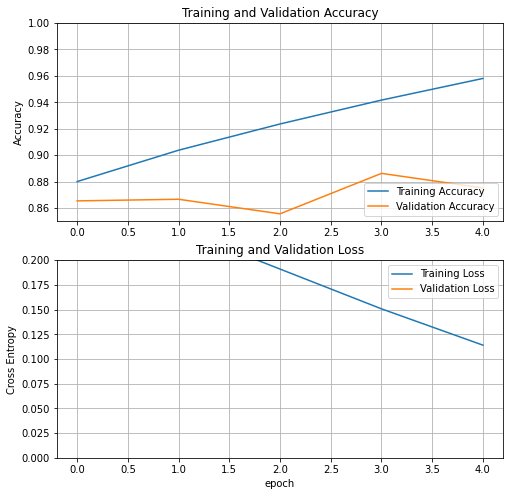

In [ ]:
# PLOTTING THE LOSS AND ACCURACY FOR EVERY APPROCHES
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')
plt.grid()

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,0.2])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.grid()
plt.show()